<a href="https://colab.research.google.com/github/curtiscu/LYIT/blob/master/Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gathering visualizations ideas

# Setup env


In [0]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Google drive access

In [2]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# test, peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# test, modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27 12:01 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27 12:01 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27 12:01 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27 12:01 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27 12:01 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27 12:01 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27 12:01 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27 12:01 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27 12:01 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27 12:01 9_soul-groove9_105_beat_4-4.mid
total 20
-rw------- 1 root root 15739 May 23 00:39 data_prep.py
drwx------ 2 root root  4096 May 10 13:31 __pycache__


## Auto reload module

Now using library code I've created and saved to google drive which is automatically pushed to the cloud and made available to the colab env. The autoreload stuff below should help imports to 'reimport' to load changes to the library code.

It's not the quickest/ most reliable, so if in a hurry, brute force loading of changes by restarting the runtime.

In [0]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

## Imports and accessing lib functions

In [5]:
# install required libs
!pip install mido

In [6]:
# imports
import pandas as pd
import math

# object that provides colours for charts
from itertools import cycle

# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep

import matplotlib.pyplot as plt


LOADING - data_prep.py module name is: data_prep


In [7]:
# testing auto reload of modules 
data_prep.test_function_call('bling')

test function called worked! :)  bling


## Pandas display options

In [0]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 200
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


## Test creating object from custom module

In [0]:
gmt = data_prep.GrooveMidiTools()

In [10]:
file_name = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid'
midi_file = data_prep.MIDI_File_Wrapper(file_name, gmt.mappings)

FILE: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid
    tracks: [<midi track 'Base Midi' 1037 messages>]
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=434783 time=0>
    last note_on: 30634
    good instruments: 4, {36.0: 'Bass Drum 1 (36)', 38.0: 'Acoustic Snare (38)', 42.0: 'Closed Hi Hat (42)', 51.0: 'Ride Cymbal 1 (51)'}


... the above verifies I'm able to create custom objects from custom code, great!


# Visualization code: prepping/ gathering vars

## Setup file to chart

In [0]:
# setup globals
file_name = ''
f = None
mtt = None
f_df = None


In [0]:

# load file to chart

def load_file(file_to_load):
  global file_name
  global f
  global mtt
  global f_df

  file_name = file_to_load
  midi_file = data_prep.MIDI_File_Wrapper(file_name, gmt.mappings)
  f = midi_file

  # capture timing data from MidiTimingTools in df...

  mtt = data_prep.MidiTimingTools(file_name, f.ticks(), f.tempo_us(), f.ts_num(), f.ts_denom(), f.last_hit())
  print(mtt)

  f_df = f.df_midi_data
  f_df = f_df[f_df['msg_type'] == 'note_on'].copy() # we only care about 'note_on' events
  beats_col, offsets_col = mtt.get_offsets(f_df[f.cum_ticks_col])
  f_df['offset'] = offsets_col
  f_df['beat'] = beats_col

## Filter data for plotting

In [0]:
# setup globals/ defaults

bar_to_start=4  # specify what bar to start chart
bars_to_render=2  # specify how many bars to include
instruments_to_render=[36, 38, 51]  # instrument filter

start_tick = 0 
end_tick = 0
instr_time_filtered_df = None
num_instruments = 0
names = ''


In [0]:

def configure_plot(start_plot_at, plot_for, plot_these_instruments):
  global f
  global bar_to_start
  global bars_to_render
  global instruments_to_render
  global mtt
  global bar_to_start
  global bars_to_render
  global start_tick
  global end_tick
  global names
  global instr_time_filtered_df
  global num_instruments

  bar_to_start = start_plot_at
  bars_to_render = plot_for
  instruments_to_render = plot_these_instruments


  # time filtering the df here to only 
  # events within the range to plot

  ts_num = f.ts_num()
  ts_den = f.ts_denom()
  ticks_per_bar=mtt.ticks_per_bar()

  # workout ticks
  start_tick, end_tick = mtt.get_tick_range(bar_to_start, bars_to_render)
  #print('start tick: {}, end tick: {}'.format(start_tick, end_tick))
  #print('total to print, ticks: {}, bars: {}'.format(end_tick - start_tick, (end_tick - start_tick) /ticks_per_bar))

  # filter our events to render
  time_filtered_df = f_df[f_df.total_ticks >= start_tick]  # chop off early ones
  time_filtered_df = time_filtered_df[time_filtered_df.total_ticks < end_tick] # chop off later ones

  # filter/ order instruments to include in chart
  # if given in params above...

  instr_in_file = time_filtered_df.note.unique()
  print('instruments in file: {}, names: {}'.format(instr_in_file, data_prep.MidiTools.getInstruments(instr_in_file)))

  instr_time_filtered_df = None 

  # instrument filtering the df here ...
  if len(instruments_to_render) == 0:
    instr_time_filtered_df = time_filtered_df[time_filtered_df['note'] != None]
    instruments_to_render = instr_time_filtered_df.note.unique().sort()
  else:
    instr_time_filtered_df = time_filtered_df[time_filtered_df['note'].isin(instruments_to_render)]

  num_instruments = len(instruments_to_render)

  names = data_prep.MidiTools.getInstruments(instruments_to_render)
  print('final instruments: {}, names: {}'.format(instruments_to_render, names ))


# Visualization code: broken_barh

## Plot the broken_barh chart





In [0]:

def do_broken_barh_plot():

  # Build data structure required by broken_barh

  bag_of_instruments = {}
  for i in instruments_to_render:
    instrument_hits = instr_time_filtered_df.loc[instr_time_filtered_df['note'] == i, 'total_ticks']
    instrument_hit_duples = []
    for i_time in instrument_hits:
      instrument_hit_duples.append((i_time, 10))

    bag_of_instruments[i] = instrument_hit_duples

  #print('bag_of_instruments: {}'.format(bag_of_instruments))

  # object that provides colours for charts
  cycol = cycle('bgrcmykw')  

  # create list for x-axis markers in plot
  bin_size = mtt.bin_size();
  my_xticks = list(range(int(start_tick) + int(bin_size/2), int(end_tick), bin_size))

  #############################################
  ## Show plot
  #############################################
  
  fig, ax = plt.subplots()
  fig.set_size_inches(12*bars_to_render, 1+num_instruments, forward=True)
  
  # loop for each instrument
  y_axis = 0
  for i in instruments_to_render:
    y_axis += 10
    ax.broken_barh(bag_of_instruments[int(i)], (y_axis, 9), facecolors=next(cycol));


  ax.set_ylim(5, (num_instruments*10)+10);
  ax.set_xlim(start_tick, end_tick);
  ax.set_xlabel('Plot for bars {} - {}'.format(bar_to_start, bar_to_start+ bars_to_render-1));
  ax.set_yticks(list(range(15, ((num_instruments+1)*10)+5, 10)));
  ax.set_yticklabels(names);

  ax.set_xticks(my_xticks);
  ax.grid(True);
  
  plt.show();




# Visualization: offset chart




## Do to plot thing

In [0]:


def do_offset_plot():

  # Building data structures for plot
  bag_of_instrument_hits = {}
  for i in instruments_to_render:
    instrument_hits = instr_time_filtered_df.loc[instr_time_filtered_df['note'] == i, 'total_ticks']
    instrument_hit_array = []
    for i_time in instrument_hits:
      instrument_hit_array.append(i_time)

    bag_of_instrument_hits[i] = instrument_hit_array


  #print('bag_of_instrument_hits: {}'.format(bag_of_instrument_hits))

  bag_of_instrument_offsets = {}
  for i in instruments_to_render:
    instrument_offsets = instr_time_filtered_df.loc[instr_time_filtered_df['note'] == i, 'offset']
    instrument_offset_array = []
    for i_time in instrument_offsets:
      instrument_offset_array.append(i_time)

    bag_of_instrument_offsets[i] = instrument_offset_array

  #print('bag_of_instrument_offsets: {}'.format(bag_of_instrument_offsets))

  # create list for x-axis markers in plot
  bin_size = mtt.bin_size();
  my_xticks = list(range(int(start_tick) + int(bin_size/2), int(end_tick), bin_size))



  fig, ax = plt.subplots();
  fig.set_size_inches(12*bars_to_render, 1+num_instruments, forward=True);
  

  # loop for each instrument
  for i in instruments_to_render:
    ax.plot(bag_of_instrument_hits[i], bag_of_instrument_offsets[i], '-o', ms= 10, label=data_prep.MidiTools.mapInstrument(i));

  ax.set(xlabel='Plot for bars {} - {}'.format(bar_to_start, bar_to_start+ bars_to_render-1), ylabel='Beat offset from norm (ticks)', title='timing offset data');

  #Add horizontal and vertical lines
  plt.axhline(0, color='black', linestyle='dotted', linewidth=4);  #horizontal line

  ax.set_xticks(my_xticks);

  #ax.grid(axis='y')
  ax.grid();
  ax.legend();

  #fig.savefig("test.png")
  plt.show();


# Testing plot functions

## Specifying file(s) to load

In [17]:
test_file_to_load = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid'
load_file(test_file_to_load)

FILE: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid
    tracks: [<midi track 'Base Midi' 1037 messages>]
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=434783 time=0>
    last note_on: 30634
    good instruments: 4, {36.0: 'Bass Drum 1 (36)', 38.0: 'Acoustic Snare (38)', 42.0: 'Closed Hi Hat (42)', 51.0: 'Ride Cymbal 1 (51)'}
LABEL: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid 
  Ticks p/beat: 480 
  BPM: 137.99987580011177 
  time sig: 4/ 4 
  bars in file: 16 
  beats in file: 64 
  ticks in file: 30720 
  bins: range(-60, 30840, 120) 
  beats: range(0, 30840, 120)


## Do some plots from the file

instruments in file: [42. 36. 51. 38.], names: ['Closed Hi Hat (42)', 'Bass Drum 1 (36)', 'Ride Cymbal 1 (51)', 'Acoustic Snare (38)']
final instruments: [36, 38, 51], names: ['Bass Drum 1 (36)', 'Acoustic Snare (38)', 'Ride Cymbal 1 (51)']


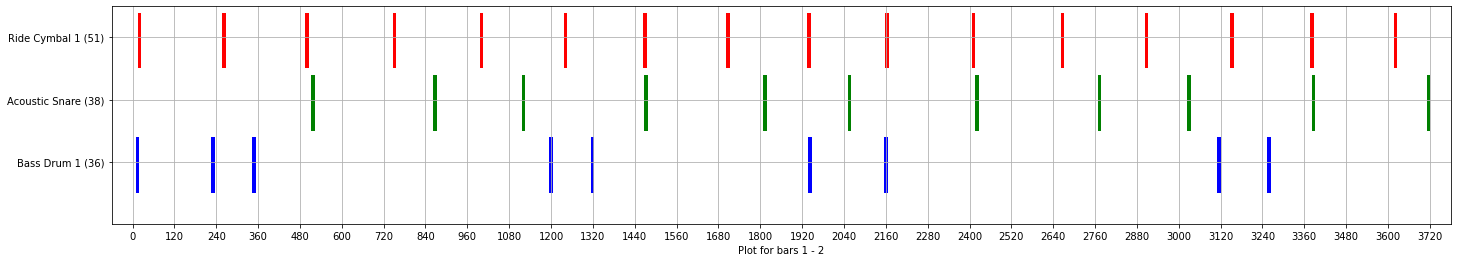

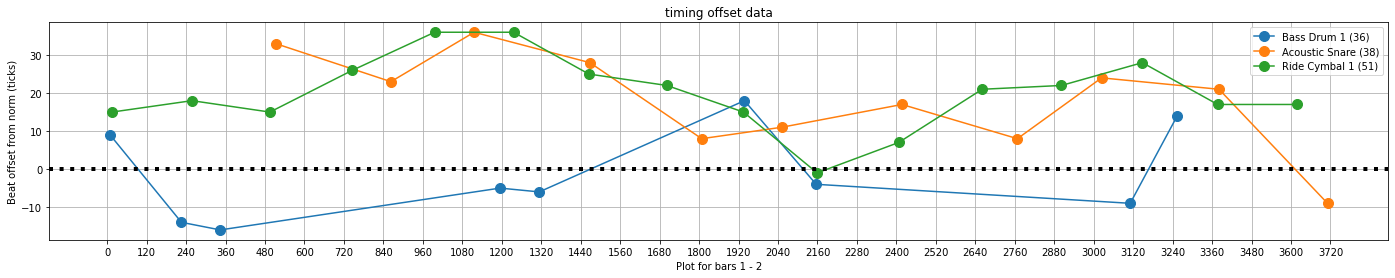

instruments in file: [51. 36. 42. 38.], names: ['Ride Cymbal 1 (51)', 'Bass Drum 1 (36)', 'Closed Hi Hat (42)', 'Acoustic Snare (38)']
final instruments: [36, 38, 51], names: ['Bass Drum 1 (36)', 'Acoustic Snare (38)', 'Ride Cymbal 1 (51)']


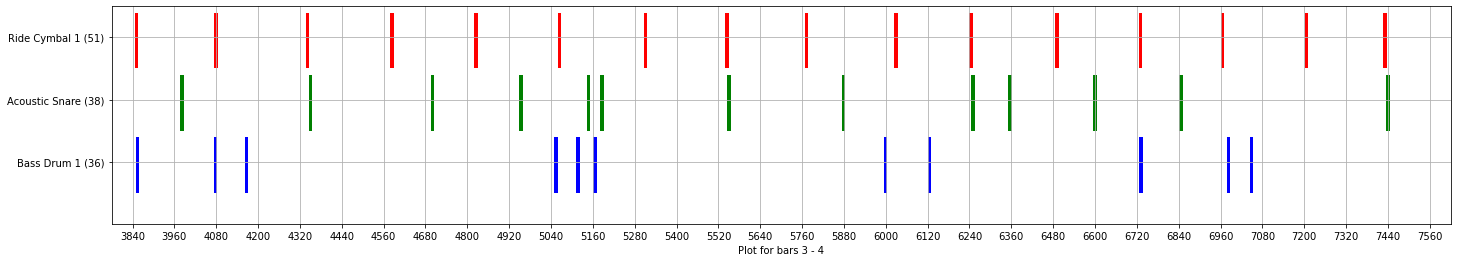

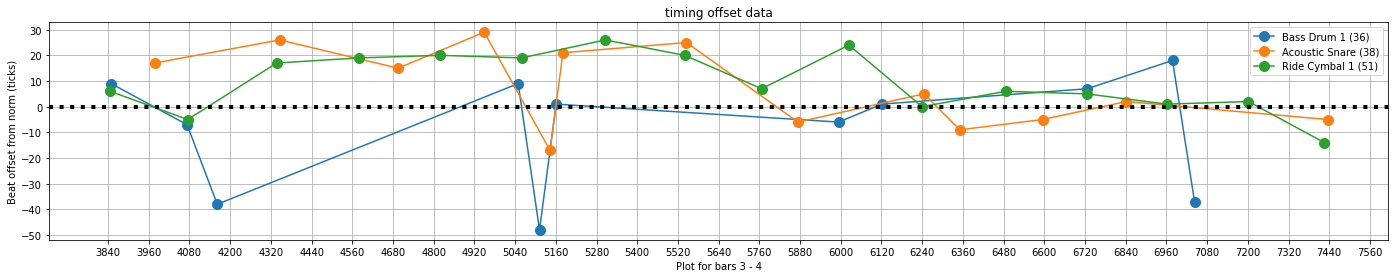

In [20]:
configure_plot(start_plot_at=1, plot_for=2, plot_these_instruments=[36, 38, 51])
do_broken_barh_plot()
do_offset_plot()
configure_plot(start_plot_at=3, plot_for=2, plot_these_instruments=[36, 38, 51])
do_broken_barh_plot()
do_offset_plot()